<a href="https://colab.research.google.com/github/HerraKaava/tensorflow/blob/main/CNNs/introduction_to_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to computer vision</h1>

Computer vision is the practice of writing algorithms that can discover patterns in visual data. One example is the camera of a self-driving car, which recognizes the cars in front of it.

<br>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pathlib
import glob
import random

In [ ]:
print(tf.__version__)

2.15.0


<h3>Load in the data</h3>

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/datasets/dansbecker/food-101

<br>

However, we've modified it to only use two classes; pizza and steak. We start with a smaller dataset so we can experiment quickly and figure out what works (or better yet, what doesn't work) before moving onto the larger dataset. Ultimately, we want our classifier to be able to tell whether images of food are pizza or steak (or neither one of them).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-07-20 08:37:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  22.1MB/s    in 5.8s    

2024-07-20 08:37:18 (17.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



<h3>Exploring the dataset</h3>

In [ ]:
# Looking inside the pizza_steak folder
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train

pizza  steak


In [ ]:
!ls pizza_steak/test

pizza  steak


In [ ]:
!ls pizza_steak/train/pizza

1008104.jpg  1572608.jpg  2097315.jpg  2572958.jpg  3084957.jpg  3693710.jpg  668944.jpg
1008144.jpg  1573562.jpg  2098014.jpg  2574896.jpg  3102271.jpg  3699992.jpg  670201.jpg
1008844.jpg  1576248.jpg  2104569.jpg  2576168.jpg  3105724.jpg  3702863.jpg  674188.jpg
1008941.jpg  1577871.jpg  2110257.jpg  2577373.jpg  3109486.jpg  3703769.jpg  676432.jpg
1011404.jpg  1584379.jpg  2112757.jpg  2577377.jpg  312479.jpg	 3704879.jpg  682201.jpg
102037.jpg   1593665.jpg  2121603.jpg  2581276.jpg  3128495.jpg  3705479.jpg  68684.jpg
1026922.jpg  1593835.jpg  2126352.jpg  2584745.jpg  3148119.jpg  370643.jpg   698251.jpg
1029698.jpg  1600705.jpg  2126709.jpg  2587918.jpg  3164761.jpg  3712344.jpg  702165.jpg
1033251.jpg  1608000.jpg  2135635.jpg  2587921.jpg  3168266.jpg  3713343.jpg  704161.jpg
1035854.jpg  1617418.jpg  2137341.jpg  259449.jpg   3170114.jpg  372275.jpg   709273.jpg
1038357.jpg  1620560.jpg  2142812.jpg  2602611.jpg  3173779.jpg  3742272.jpg  709947.jpg
1040878.jpg  1620761.jp

- Looks like the train folder contains a lot of images.

In [ ]:
for dir_path, dir_names, file_names in os.walk("/content/pizza_steak"):
    if len(file_names) != 0:
        print(f"There are {len(file_names)} images in {dir_path}")

There are 250 images in /content/pizza_steak/test/steak
There are 250 images in /content/pizza_steak/test/pizza
There are 750 images in /content/pizza_steak/train/steak
There are 750 images in /content/pizza_steak/train/pizza


In [ ]:
# Class names
data_dir = pathlib.Path("/content/pizza_steak/train")
class_names = [item.name for item in data_dir.glob(pattern="*")]

- "*" is a wildcar symbol, which means that any letters are accepted.

In [ ]:
class_names

['steak', 'pizza']

In [ ]:
# Visualize images
def view_random_img(img_dir, img_class):
    """
    Picks a random image from a given folder of a given class.

    Args:
    img_dir -- directory where the images are located
    img_class -- class of the img that you wish to visualize

    Returns:
    img -- a random image
    """
    img_folder = img_dir + img_class
    img_names_list = os.listdir(img_folder)

    # This returns a list, with one element, so we need to index the element out
    random_image = random.sample(population=img_names_list, k=1)

    # Read in the image using matplotlib.image
    img = mpimg.imread(fname=img_folder + "/" + random_image[0])

    # Print the shape of the image
    print(f"Shape of the image: {img.shape}")
    print()

    # Plot the iamge
    plt.figure(figsize=(6,4), dpi=150)
    plt.title(img_class, size=12)
    plt.axis("off")
    plt.imshow(img);

    return img

Shape of the image: (512, 512, 3)



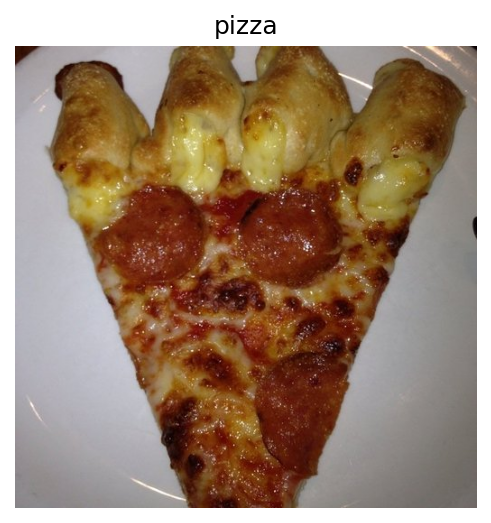

In [ ]:
img = view_random_img("/content/pizza_steak/test/", "pizza")

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
img.dtype

dtype('uint8')

In [ ]:
img[:3, :3, :]

array([[[49, 16,  7],
        [51, 18,  9],
        [51, 18,  9]],

       [[49, 16,  7],
        [51, 18,  9],
        [52, 19, 10]],

       [[50, 18,  7],
        [52, 20,  9],
        [52, 20,  9]]], dtype=uint8)

- Inputs to the neural network will be these kinds of tensors, where the elements represents pixels of the image: (pixel_width, pixel_height, num_color_channels).
- The images are usually collapsed such that one image represents a column vector: $(\text{pixel_width} \, * \, \text{pixel_height} \, * \, \text{num_color_channels}, 1)$

In [ ]:
# Collapse the image (tensor) into a column vector
reshaped_img = img.reshape(-1, 1)

In [ ]:
reshaped_img.shape

(786432, 1)

In [ ]:
# NNs tend to perform better with normalized data
# Let's normalize our image to have pixel values between 0 and 1
# To do this, divide all of the elements by the max value (pixel) of the image
max_val = float(np.max(reshaped_img))
img_reshaped_scaled = reshaped_img / max_val

In [ ]:
print(f"Maximum value of reshaped_img: {max_val}")
print(np.max(img_reshaped_scaled))
print(np.min(img_reshaped_scaled))

Maximum value of reshaped_img: 255.0
1.0
0.0


- Bravo.

As said above, many ML models, including NNs, prefer to work with values between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also known as **normalizing**) the pixel values by dividing the image arrays by 255 (the maximum pixel value for a standard RGB image, where each color channel is represented by *8-bits*, is 255 (bit depth refers to the number of bits used to represent the color of a single pixel)).

<h3>Building a Convolution Neural Network (CNN)</h3>

1. Load the images
2. Preprocess the images
3. Build a CNN to find patterns in the images
4. Compile the CNN
5. Fit the CNN to the training data

In [ ]:
tf.random.set_seed(42)

In [ ]:
# Preprocess the images (scale the pixels to have values between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/pizza_steak/train"
valid_dir = "/content/pizza_steak/test"

In [ ]:
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(244, 244),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.


In [ ]:
# Same for validation data
valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                               batch_size=32,
                                               target_size=(244, 244),
                                               class_mode="binary",
                                               seed=42)

Found 500 images belonging to 2 classes.


- **directory**: path to the directory containing the images.
- **batch_size**: controls the batch sizes in the training of the CNN. If for example batch_size=32, then 32 images will be loaded and processed at each iteration.
- **target_size**: reshapes all the images to this shape.
- **class_mode**: the number of classes we're working with.

Notice that when we specify batch_size=32, we will have $\, k = \frac{\text{num_examples}}{32} \,$ batches of images, where each batch has 32 images.

In [ ]:
batch_size=32
num_steak_train_imgs = len(os.listdir("/content/pizza_steak/train/pizza"))
num_pizza_train_imgs = len(os.listdir("/content/pizza_steak/train/steak"))
total_train_imgs = num_steak_train_imgs + num_pizza_train_imgs
num_train_batches = int(np.round(total_train_imgs / batch_size))
print(f"Within our training data, we have {num_train_batches} batches.")

Within our training data, we have 47 batches.


In [ ]:
# Verify that our training data indeed has 47 batches
len(train_data)

47

<h3>Building a demo CNN model</h3>

In [ ]:
# Architecture of the CNN model
model_1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(244, 244, 3)),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu"),

    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu"),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu"),

    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=1, activation="sigmoid")

])

# Compile the CNN model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
loss_history_model_1 = model_1.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=valid_data,
                                   validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 142ms/step - loss: 0.5662 - accuracy: 0.6987 - val_loss: 0.4177 - val_accuracy: 0.8600
Epoch 2/5
47/47 [==============================] - 7s 156ms/step - loss: 0.4350 - accuracy: 0.8100 - val_loss: 0.3531 - val_accuracy: 0.8640
Epoch 3/5
47/47 [==============================] - 6s 132ms/step - loss: 0.3952 - accuracy: 0.8307 - val_loss: 0.3303 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 7s 139ms/step - loss: 0.3612 - accuracy: 0.8493 - val_loss: 0.2972 - val_accuracy: 0.8920
Epoch 5/5
47/47 [==============================] - 6s 136ms/step - loss: 0.3278 - accuracy: 0.8633 - val_loss: 0.2903 - val_accuracy: 0.8860


In [ ]:
type(loss_history_model_1.history)

dict

In [ ]:
loss_history_model_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

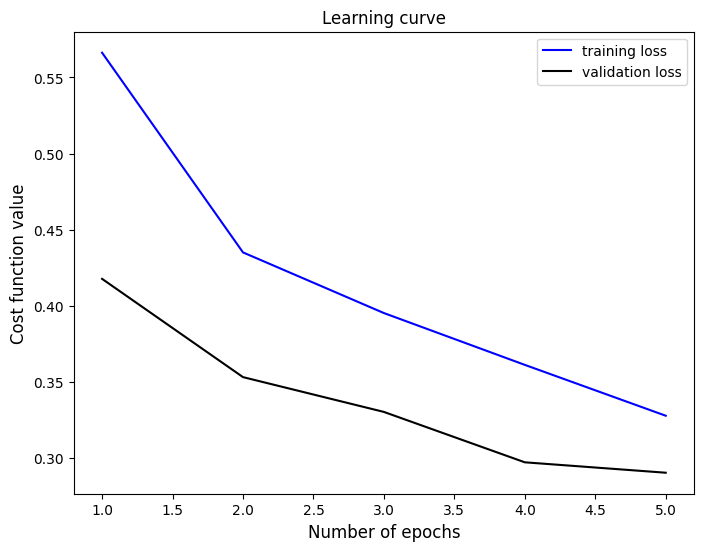

In [ ]:
# Visualize the learning curve (both training and validation)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.plot(np.arange(1, 6), loss_history_model_1.history["loss"], color="blue", label="training loss")
ax.plot(np.arange(1, 6), loss_history_model_1.history["val_loss"], color="black", label="validation loss")
ax.set_title("Learning curve", size=12)
ax.set_xlabel("Number of epochs", size=12)
ax.set_ylabel("Cost function value", size=12)
plt.legend();

<h3>A quick note on neurons</h3>

A neuron can be thought of as a function that takes in multiple inputs and yields a single output. Described more mathematically, a neuron is a function that takes in multiple inputs, performs linear transformation on those inputs and their corresponding weights using dot product, adds a bias to the dot product output, and finally, adds a non-linearity to the shifted linear transformation. With mathematical notation, the operator inside a neuron can be represented as follows:

\begin{align*}
    g(WX \, + \, b),
\end{align*}

where $\, WX \,$ is the dot product between the inputs $\, X \,$ and their corresponding weights $\, W, \,$ $\, b \,$ is the bias that shifts the linear transformation, and $\, g() \,$ is the non-linear activation function that is applied to the shifted linear transformation.

Some clarification on the used terminology:

- **Inputs** ($X$): these are the features or "signals" received by the neuron.
- **Weights** ($W$): these are the parameters that determine the importance of each input (each input has a corresponding weight).
- **Bias** ($b$): this is an additional parameter that allows the activation function $\, g() \,$ to be shifted.

Note that the dot product is just a weighted sum between the inputs $X$ and their corresponding weights $W$:

\begin{align*}
    \sum_{i=1}^{n} X_i \, \cdot \, W_i
\end{align*}

Note that the **layers** of a neural network are just a collection of neurons with the same **operation**, including the same *hyperparameters*.

For more information, see: https://poloclub.github.io/cnn-explainer/

<h3>A quick note on max pooling</h3>

Max pooling is a technique used to reduce the dimensionality of the *activation maps*. Max pooling helps by reducing the computational complexity, controlling overfitting, and summarizing the most important features detected by the convolutional layers.

<br>

The sequence of operations in a CNN is as follows:

1. **Convolution operation**: convolutional layers apply *kernels* (*filters*) to the input data (or previous layer's output), producing intermediate *feature maps*.

2. **Activation function**: non-linear activation functions (e.g., ReLU) are applied to these feature maps, resulting in what are commonly referred to as *activation maps*.

3. **Max pooling**: the max pooling operation is applied to these activation maps, effectively reducing their spatial dimensions.

<br>

Let's examine the sequence of operations in a CNN with an illustrative example. Suppose that our input matrix is:

<br>
\begin{bmatrix}
    1 & 2 & 3 & 4 \\
    5 & 6 & 7 & 8 \\
    9 & 10 & 11 & 12 \\
    13 & 14 & 15 & 16 \\
\end{bmatrix}
<br>

**Step 1**. Apply convolution operation with a $\, 2x2 \,$ filter. The filter could look as follows:

<br>
\begin{bmatrix}
    0 & 2 \\
    4 & 1
\end{bmatrix}
<br>

This filter is moved through the whole input matrix (according to the *stride* value) such that it covers every part of it, producing a *feature map*. A single element of the feature map is an element-wise dot product of the filter values and the input matrix values that they are currently "sitting"  on (i.e., the part of the input matrix that the $\, 2x2 \,$ filter currently covers). For example, a single element of the feature map, starting from the top left, would be:

<br>
$$
\begin{bmatrix}
1 & 2 \\
5 & 6
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 30
$$
<br>

*Stride* indicates how many pixels the filter should be shifted over at a time. Suppose our stride value is 1. Then, we would move one pixel to the right to perform the next element-wise dot product:

<br>
$$
\begin{bmatrix}
2 & 3 \\
6 & 7
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 37
$$
<br>

We continue this until we have covered all the parts of the input matrix:

<br>
$$
\begin{bmatrix}
3 & 4 \\
7 & 8
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 44
$$
<br>

<br>
$$
\begin{bmatrix}
5 & 6 \\
9 & 10
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 58
$$
<br>

<br>
$$
\begin{bmatrix}
6 & 7 \\
10 & 11
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 65
$$
<br>

<br>
$$
\begin{bmatrix}
7 & 8 \\
11 & 12
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 72
$$
<br>

<br>
$$
\begin{bmatrix}
9 & 10 \\
13 & 14
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 86
$$
<br>

<br>
$$
\begin{bmatrix}
10 & 11 \\
14 & 15
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 93
$$
<br>

<br>
$$
\begin{bmatrix}
11 & 12 \\
15 & 16
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 100
$$
<br>

Putting these together gives us the *feature map*:

<br>
\begin{align*}
\text{Feature map} =
\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix}
\end{align*}
<br>

**Step 2**: Apply the non-linear activation function (ReLU) to obtain the *activation map*. $\, ReLU(z) = \text{max}(0, z). \,$ Notice that the ReLU is applied element-wise to every element in the feature map.

<br>
\begin{align*}
    \text{Activation map}=
    ReLU \left(\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix} \right) = \begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix}
\end{align*}
<br>

**Step 3**: Max pooling operation $\, (2x2) \,$ with a stride of 1. This means that we slide the $\, (2x2) \,$ "window" through the *activation map* one pixel at a time such that every part gets covered, and with each iteration, select the maximum value out of that "window". This effectively reduces the spatial dimension of the activation map.

<br>
\begin{align*}
    \text{Reduced activation map}=
    \text{MaxPool} \left(\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix} \right) = \begin{bmatrix}
    65 & 72  \\
    93 & 100
\end{bmatrix}
\end{align*}
<br>

**Summary**:

- Starting from the input image, we applied a $\, 2x2 \,$ kernel to perform convolution, followed by the ReLU activation function. Afterward, we applied a $\, 2x2 \,$ max pooling operation with a stride of 1, resulting in a $\, 2x2 \,$ output activation map that retains the most prominent features from the original input. This process effectively reduces the spatial dimensions while retaining the most significant values from each pooling region.